In [322]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline
plt.style.use('ggplot')

In [323]:
df = pd.read_excel('Тестовое задание - Анализ заказов ПВЗ (данные).xlsx', index_col=0)
df.head(2)

,Day,DelivType,PymentType,Journal_id,_ktt1,_ktt2,_ktt3,_itemid,_colorid,_Approved_USD,_Approved_PCS,_Net_USD,_Net_PCS
Week,,,,,,,,,,,,,
Week 17 (23.11.20-29.11.20),2020-11-27,ЦУМ - Самовывоз,Prepaid,EO01386067,Товары для мужчин,Аксессуары из кожи,Ремни,7625454,Черный_BLACK,360.80,1,0.00,0
Week 23 (04.01.21-10.01.21),2021-01-09,ЦУМ - Самовывоз,Postpaid,EO01496554,Товары для мужчин,Аксессуары из кожи,Ремни,7625454,Черный_BLACK,240.88,1,240.88,1


In [324]:
df.describe()

,_itemid,_Approved_USD,_Approved_PCS,_Net_USD,_Net_PCS
count,525466.00,525466.00,525466.00,525466.00,525466.00
mean,6675314.19,525.53,0.89,264.67,0.64
std,1378683.63,517.95,0.56,447.37,0.58
min,4008842.00,0.00,0.00,0.00,0.00
25%,4749996.00,111.68,1.00,0.00,0.00
50%,7305565.00,402.67,1.00,12.00,1.00
75%,7655575.00,791.73,1.00,401.25,1.00
max,7995595.00,26381.51,33.00,15581.91,33.00


In [325]:
df.describe(include='object')

,DelivType,PymentType,Journal_id,_ktt1,_ktt2,_ktt3,_colorid
count,525466,525466,525466,525466,525466,525466,421490
unique,1,2,195760,4,11,154,27537
top,ЦУМ - Самовывоз,Postpaid,EO01583735,Товары для женщин,Одежда,Услуги,Черный_BLACK
freq,525466,490577,66,266291,210592,103088,18723


In [326]:
df['Month'] = df['Day'].dt.to_period('M')
confirmed_orders = df[df['_Approved_PCS'] > 0]
print(df[df['_ktt2'] == 'Услуги']['_Approved_PCS'].sum()) # Заказ услуги не подтверждался ни разу.


0


In [327]:
print(confirmed_orders['_ktt2'].unique()) 

['Аксессуары из кожи' 'Бижутерия' 'Одежда' 'Аксессуары' 'Обувь' 'Сумки'
 'Подарочные карты' 'Домашняя, пляжная одежда' 'Рюкзак дорожный' 'Чемодан']


Рекомендуется уточнить у бизнеса, куда отнести айтемы, не относящиеся ни к одной категории. 
Например, 'Домашняя, пляжная одежда' может также относиться к категории товаров, которые можно мерить. Тогда для целей данной задачи категории следовало бы совместить. 

In [328]:
order_statistics = confirmed_orders.groupby(['Journal_id', 'Month']).agg({
    '_ktt2': lambda x: x.value_counts().to_dict(),
    '_Approved_PCS': 'sum',  
    '_Approved_USD': 'sum',  
    '_Net_PCS': 'sum',       
    '_Net_USD': 'sum'       
}).reset_index()

order_statistics.rename(columns={
    '_ktt2': 'KTT2_Count_Per_Item',
    '_Approved_PCS': 'Total_Items_Ordered',
    '_Approved_USD': 'Total_Order_Value',
    '_Net_PCS': 'Total_Bought_Items',
    '_Net_USD': 'Total_Bought_Value'
}, inplace=True)

expanded_ktt2_counts = order_statistics['KTT2_Count_Per_Item'].apply(pd.Series).fillna(0).astype(int)
order_statistics_expanded = pd.concat([order_statistics, expanded_ktt2_counts], axis=1).drop('KTT2_Count_Per_Item', axis=1)

In [329]:
order_statistics_expanded['Group'] = 'другие'
order_statistics_expanded.loc[order_statistics_expanded['Одежда']>=1, 'Group'] = 'нужна примерка в примерочной'
order_statistics_expanded.loc[order_statistics_expanded['Обувь']  == order_statistics_expanded['Total_Items_Ordered'], 'Group'] = 'легко примерить в зале'
order_statistics_expanded.loc[order_statistics_expanded['Сумки'] == order_statistics_expanded['Total_Items_Ordered'], 'Group'] = 'примерка не нужна'
order_statistics_expanded.head(5)

,Journal_id,Month,Total_Items_Ordered,Total_Order_Value,Total_Bought_Items,Total_Bought_Value,Аксессуары,Аксессуары из кожи,Обувь,"Домашняя, пляжная одежда",Одежда,Сумки,Бижутерия,Подарочные карты,Рюкзак дорожный,Чемодан,Group
0,EO01310953,2020-10,6,4917.50,0,0.00,4,2,0,0,0,0,0,0,0,0,другие
1,EO01310959,2020-10,1,1399.12,0,0.00,0,0,1,0,0,0,0,0,0,0,легко примерить в зале
2,EO01310961,2020-10,1,69.43,1,69.43,0,0,0,1,0,0,0,0,0,0,другие
3,EO01310963,2020-10,2,2633.11,0,0.00,0,0,2,0,0,0,0,0,0,0,легко примерить в зале
4,EO01310966,2020-10,1,864.15,1,864.15,0,0,0,0,1,0,0,0,0,0,нужна примерка в примерочной


# 1

In [330]:
res = order_statistics_expanded.groupby(['Month', 'Group'])['Journal_id'].count().reset_index().rename(columns={"Journal_id": 'Order_count'})
res['Percentage_Total_Count'] = res.groupby('Month')['Order_count'].transform(lambda x: (x / x.sum()) * 100)

res.head()

,Month,Group,Order_count,Percentage_Total_Count
0,2020-10,другие,1491,27.83
1,2020-10,легко примерить в зале,1105,20.63
2,2020-10,нужна примерка в примерочной,2543,47.47
3,2020-10,примерка не нужна,218,4.07
4,2020-11,другие,2764,29.72


In [331]:
wide_res = res.pivot_table(index='Group', columns='Month', values='Percentage_Total_Count', aggfunc='sum')
wide_res.reset_index(inplace=True)
wide_res.columns.name = None
wide_res

,Group,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,другие,27.83,29.72,37.16,22.60,25.99,27.29,24.41,24.32,22.75,20.41,17.75,25.92,26.27
1,легко примерить в зале,20.63,17.66,13.02,21.27,18.46,17.72,20.69,19.31,20.58,20.00,19.78,19.56,17.04
2,нужна примерка в примерочной,47.47,47.87,43.59,50.01,49.54,47.86,48.02,49.68,50.11,53.17,57.53,48.53,50.42
3,примерка не нужна,4.07,4.75,6.24,6.12,6.01,7.14,6.89,6.69,6.56,6.42,4.94,5.99,6.27


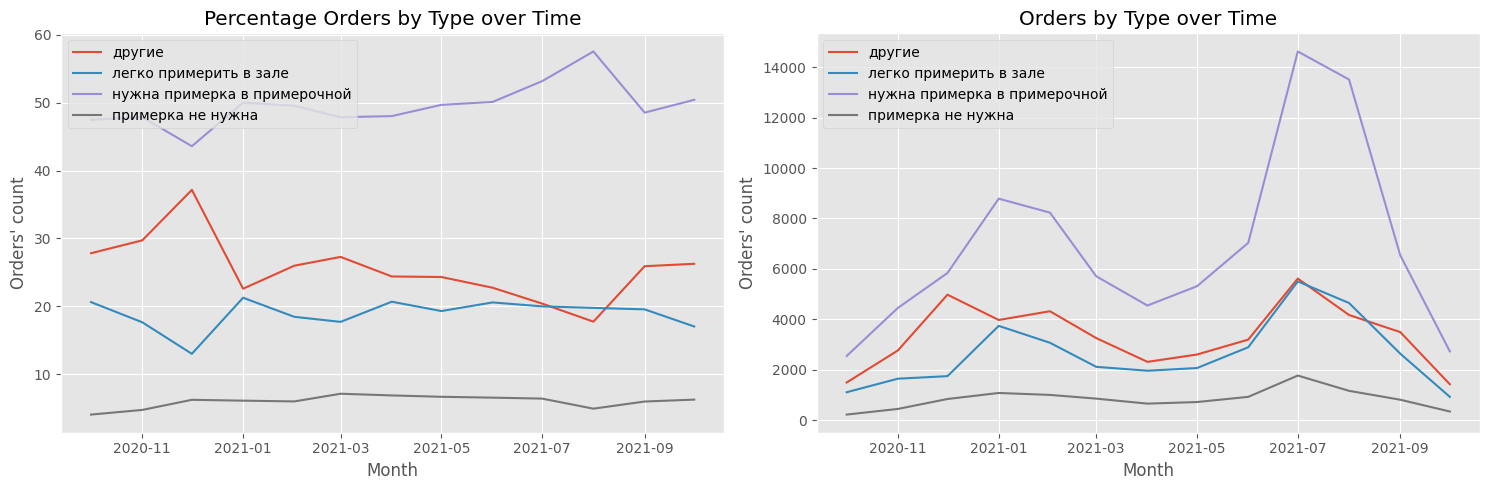

In [332]:
if res['Month'].dtype != '<M8[ns]':
    res['Month'] = res['Month'].dt.to_timestamp()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
sns.lineplot(data=res, x='Month', y='Percentage_Total_Count', hue='Group', ax=axes[0])
axes[0].set_title('Percentage Orders by Type over Time')
axes[0].set_xlabel('Month')
axes[0].set_ylabel("Orders' count")
axes[0].legend(loc='upper left')

sns.lineplot(data=res, x='Month', y='Order_count', hue='Group', ax=axes[1])
axes[1].set_title('Orders by Type over Time')
axes[1].set_xlabel('Month')
axes[1].set_ylabel("Orders' count")
axes[1].legend(loc='upper left')

plt.tight_layout() 
plt.show()

C:\Users\Natas\AppData\Local\Temp\ipykernel_23768\2815304061.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25)
C:\Users\Natas\AppData\Local\Temp\ipykernel_23768\2815304061.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=25)


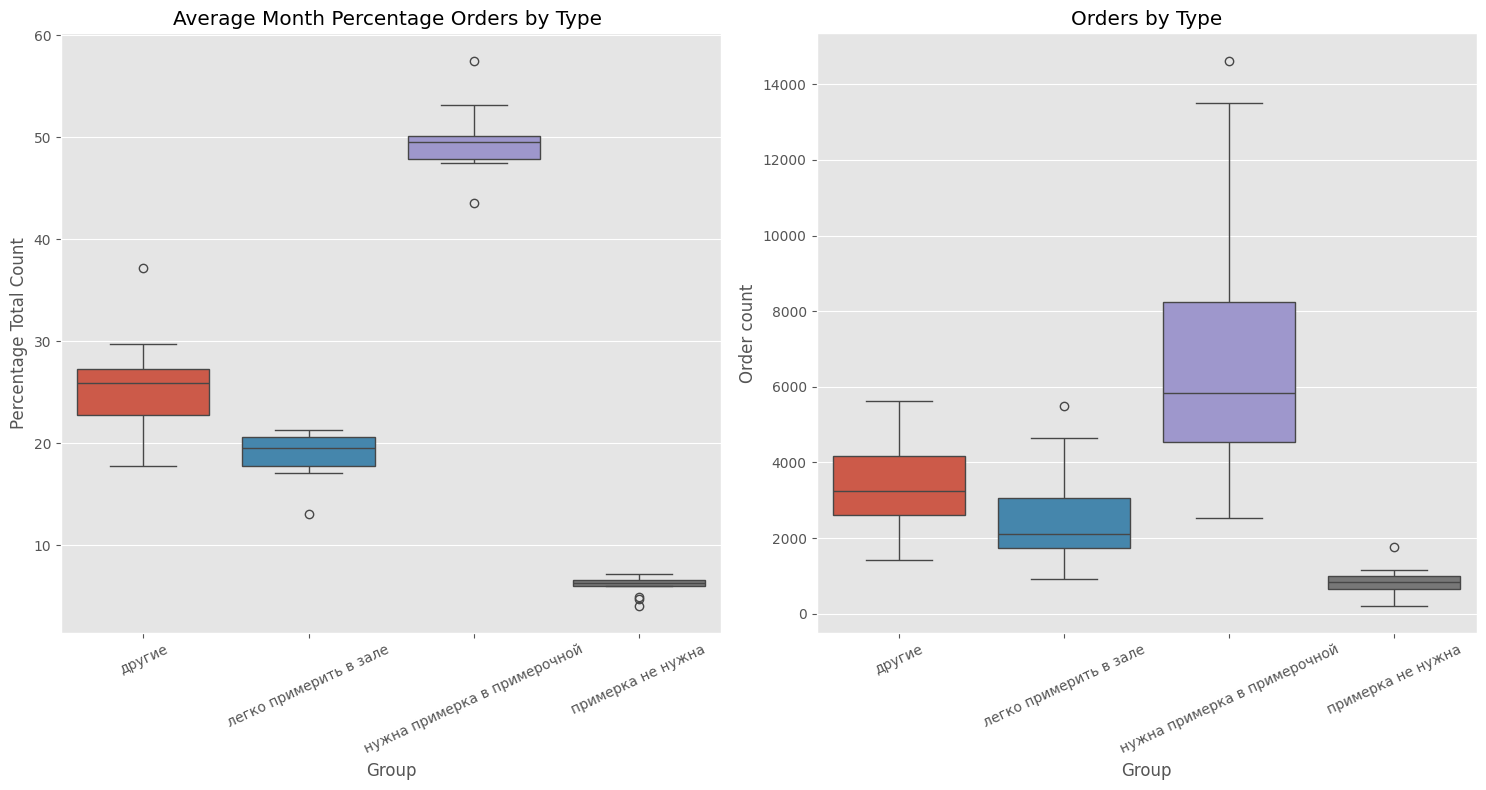

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8)) 
sns.boxplot(data=res, x='Group', y='Percentage_Total_Count', hue='Group',  ax=axes[0])
axes[0].set_title('Average Month Percentage Orders by Type ')
axes[0].set_xlabel('Group')
axes[0].set_ylabel("Percentage Total Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25)  

sns.boxplot(data=res, x='Group', y='Order_count', hue='Group',  ax=axes[1])
axes[1].set_title('Orders by Type')
axes[1].set_xlabel('Group')
axes[1].set_ylabel("Order count")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=25)  

plt.tight_layout() 
plt.show()

In [334]:
# подсчёт общих аггрегированных статистик
additional_aggregations = res.groupby(['Group'])['Order_count'].agg([
    'max', 'min', 'median', 'mean',
    lambda x: x.quantile(0.75) - x.quantile(0.25),  
    lambda x: x.quantile(0.25), 
    lambda x: x.quantile(0.75)
]).reset_index().rename(columns={
    '<lambda_0>': 'IQR',
    '<lambda_1>': '25th_percentile',
    '<lambda_2>': '75th_percentile'
})
additional_aggregations = additional_aggregations.round(2)
additional_aggregations

,Group,max,min,median,mean,IQR,25th_percentile,75th_percentile
0,другие,5615,1420,3254.00,3352.00,1569.00,2601.00,4170.00
1,легко примерить в зале,5503,921,2113.00,2617.38,1325.00,1743.00,3068.00
2,нужна примерка в примерочной,14628,2543,5837.00,6911.85,3688.00,4545.00,8233.00
3,примерка не нужна,1766,218,836.00,829.23,346.00,652.00,998.00


In [335]:
# подсчёт относительных аггрегированных статистик 
additional_aggregations_percentage = res.groupby(['Group'])['Percentage_Total_Count'].agg([
    'max', 'min', 'median', 'mean',
    lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR
    lambda x: x.quantile(0.25),  
    lambda x: x.quantile(0.75)  
]).reset_index().rename(columns={
    '<lambda_0>': 'IQR',
    '<lambda_1>': '25th_percentile',
    '<lambda_2>': '75th_percentile'
})
additional_aggregations_percentage = additional_aggregations_percentage.round(2)
additional_aggregations_percentage

,Group,max,min,median,mean,IQR,25th_percentile,75th_percentile
0,другие,37.16,17.75,25.92,25.57,4.54,22.75,27.29
1,легко примерить в зале,21.27,13.02,19.56,18.90,2.86,17.72,20.58
2,нужна примерка в примерочной,57.53,43.59,49.54,49.52,2.24,47.87,50.11
3,примерка не нужна,7.14,4.07,6.24,6.01,0.57,5.99,6.56


# Выводы

1. Группа "легко примерить в зале" составляет около 20% от всех заказов и в 2.5. раза меньше заказов категории "нужна примерка в примерочной". При допущении, что места для примерки обуви уже есть в ПВЗ, значительно увеличить эффективность обслуживания за счёт дополнительного места для примерки обуви не представляется возможным.

2. Группа "примерка не нужна" имеет наименьшее среднее количество заказов. Тем не менее для данной категории постамат потенциально может уменьшить время обслуживания (при допущении, что ранее для данной категории приходилось стоять в общей очереди). Окупаемость необходимо уточнять дополнительно.

3. В группе "нужна примерка в примерочной" наблюдается более высокое количество заказов по сравнению с группами "легко примерить в зале" и "примерка не нужна". Здесь требуются дополнительные меры по улучшению сервиса или оптимизации процессов, чтобы уменьшить время ожидания или повысить эффективность обслуживания. Возможно следует рассмотреть реорганизацию ПВЗ (напр. всё же изыскать возможность добавления примерочной) или открытие дополнительного ПВЗ.

4. Рекомендуется также собрать данные о среднем времени обслуживания, загруженности ПВЗ. Опрос покупателей поможет понять их потребности и оценить уровень удовлетворенности обслуживанием. Также можно рассмотреть общую оптимизацию рабочих процессов. Это может включать перераспределение персонала в пиковые часы, внедрение более эффективных систем работы и обучение персонала для улучшения обслуживания клиентов.

# 2

In [336]:
easy_to_wear = order_statistics_expanded[order_statistics_expanded['Group'] == 'легко примерить в зале']
easy_to_wear.head(2)

,Journal_id,Month,Total_Items_Ordered,Total_Order_Value,Total_Bought_Items,Total_Bought_Value,Аксессуары,Аксессуары из кожи,Обувь,"Домашняя, пляжная одежда",Одежда,Сумки,Бижутерия,Подарочные карты,Рюкзак дорожный,Чемодан,Group
1,EO01310959,2020-10,1,1399.12,0,0.00,0,0,1,0,0,0,0,0,0,0,легко примерить в зале
3,EO01310963,2020-10,2,2633.11,0,0.00,0,0,2,0,0,0,0,0,0,0,легко примерить в зале


In [337]:
easy_to_wear.groupby([ 'Обувь'])['Journal_id'].count().reset_index().rename(columns={'Journal_id':'order_count'})

,Обувь,order_count
0,1,25887
1,2,4193
2,3,1912
3,4,900
4,5,457
5,6,274
6,7,140
7,8,118
8,9,130
9,10,10


Несколько категорий представлены очень в малом количестве. Мы объединим редкие типы заказов в общие категории.

In [338]:
bins = [1, 2, 3, 4, 6, float('inf')]  # bins: 1, 2, 3, 4-5, 6+
labels = ['1', '2', '3', '4-5', '6+']
easy_to_wear['item_count_bin'] = pd.cut(easy_to_wear['Обувь'], bins=bins, labels=labels, right=False)

C:\Users\Natas\AppData\Local\Temp\ipykernel_23768\2414213667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easy_to_wear['item_count_bin'] = pd.cut(easy_to_wear['Обувь'], bins=bins, labels=labels, right=False)


In [339]:
summary = easy_to_wear.groupby([ 'item_count_bin', 'Month'])['Journal_id'].count().reset_index().rename(columns={'Journal_id':'order_count'})
summary.sample(2)

,item_count_bin,Month,order_count
26,3,2020-10,60
23,2,2021-08,585


In [340]:
wide_df = summary.pivot_table(index='item_count_bin', columns='Month', values='order_count', aggfunc='sum')
wide_df.reset_index(inplace=True)
wide_df.columns.name = None
wide_df

,item_count_bin,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,1,847,1255,1296,2913,2440,1607,1413,1420,2158,4178,3587,2056,717
1,2,122,206,194,457,325,257,266,320,360,684,585,303,114
2,3,60,93,167,181,141,120,132,160,188,286,226,112,46
3,4-5,51,54,52,126,109,89,97,120,123,232,166,111,27
4,6+,25,34,34,61,53,40,50,45,60,123,82,53,17


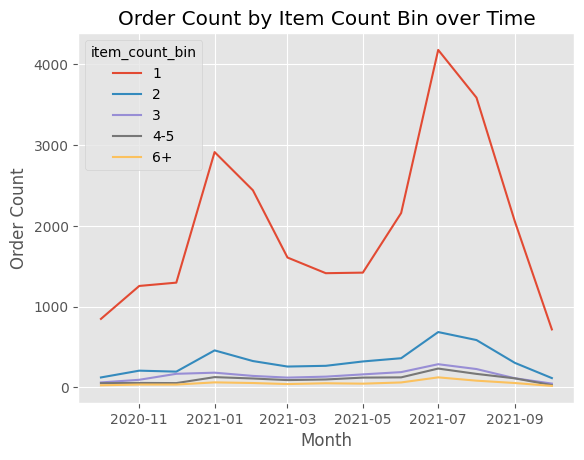

In [341]:
if summary['Month'].dtype != '<M8[ns]':
    summary['Month'] = summary['Month'].dt.to_timestamp()
summary['order_count'] = pd.to_numeric(summary['order_count'], errors='coerce')
sns.lineplot(data=summary, x='Month', y='order_count', hue='item_count_bin')
plt.title('Order Count by Item Count Bin over Time')
plt.xlabel('Month')
plt.ylabel('Order Count')
plt.show()

In [342]:
additional_aggregations1 = summary.groupby(['item_count_bin'])['order_count'].agg([
    'max', 'min', 'median', 'mean',
    lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR
    lambda x: x.quantile(0.25),  
    lambda x: x.quantile(0.75)  
]).reset_index().rename(columns={
    '<lambda_0>': 'IQR',
    '<lambda_1>': '25th_percentile',
    '<lambda_2>': '75th_percentile'
})
additional_aggregations1['mean_of_the_total'] = additional_aggregations1['mean'] / sum(additional_aggregations1['mean'])
additional_aggregations1 = additional_aggregations1.round(2)
additional_aggregations1

,item_count_bin,max,min,median,mean,IQR,25th_percentile,75th_percentile,mean_of_the_total
0,1,4178,717,1607.00,1991.31,1144.00,1296.00,2440.00,0.76
1,2,684,114,303.00,322.54,154.00,206.00,360.00,0.12
2,3,286,46,141.00,147.08,69.00,112.00,181.00,0.06
3,4-5,232,27,109.00,104.38,69.00,54.00,123.00,0.04
4,6+,123,17,50.00,52.08,26.00,34.00,60.00,0.02


# 2А

In [345]:
easy_to_wear['%_confirmed'] = easy_to_wear['Total_Bought_Items'] / easy_to_wear['Total_Items_Ordered'] * 100

C:\Users\Natas\AppData\Local\Temp\ipykernel_23768\2073775383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  easy_to_wear['%_confirmed'] = easy_to_wear['Total_Bought_Items'] / easy_to_wear['Total_Items_Ordered'] *100


In [346]:
easy_to_wear['%_confirmed'].mean()

49.79527697985642

In [347]:
summary1 = easy_to_wear.groupby([ 'item_count_bin', 'Month'])['%_confirmed'].mean().reset_index().rename(columns={'Journal_id':'order_count'})
summary1.sample(6)

,item_count_bin,Month,%_confirmed
53,6+,2020-11,53.80
14,2,2020-11,52.43
59,6+,2021-05,50.15
49,4-5,2021-08,52.08
29,3,2021-01,47.33
44,4-5,2021-03,51.12


In [348]:
wide_df1 = summary1.pivot_table(index='item_count_bin', columns='Month', values='%_confirmed', aggfunc='mean')
wide_df1.reset_index(inplace=True)
wide_df1.columns.name = None
wide_df1

,item_count_bin,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10
0,1,47.93,49.64,49.46,50.98,50.29,49.66,49.68,47.54,49.68,49.52,50.13,50.92,50.35
1,2,46.72,52.43,48.71,50.33,47.23,48.83,47.93,52.97,49.58,49.56,52.82,51.32,48.68
2,3,48.33,48.39,48.10,47.33,47.52,51.11,47.22,48.12,48.05,48.48,52.36,49.70,52.90
3,4-5,42.16,51.94,47.88,48.41,50.78,51.12,48.92,46.42,50.16,49.44,52.08,48.06,42.96
4,6+,48.12,53.80,48.90,47.92,54.94,51.00,48.72,50.15,48.23,48.72,48.95,47.39,43.24


In [349]:
additional_aggregations_percentage1 = summary1.groupby(['item_count_bin'])['%_confirmed'].agg([
    'max', 'min', 'median', 'mean',
    lambda x: x.quantile(0.75) - x.quantile(0.25),  # IQR
    lambda x: x.quantile(0.25),  
    lambda x: x.quantile(0.75)  
]).reset_index().rename(columns={
    '<lambda_0>': 'IQR',
    '<lambda_1>': '25th_percentile',
    '<lambda_2>': '75th_percentile'
})
additional_aggregations_percentage1 = additional_aggregations_percentage1.round(2)
additional_aggregations_percentage1

,item_count_bin,max,min,median,mean,IQR,25th_percentile,75th_percentile
0,1,50.98,47.54,49.68,49.67,0.77,49.52,50.29
1,2,52.97,46.72,49.56,49.78,2.64,48.68,51.32
2,3,52.90,47.22,48.33,49.05,1.65,48.05,49.70
3,4-5,52.08,42.16,48.92,48.49,2.90,47.88,50.78
4,6+,54.94,43.24,48.72,49.24,2.03,48.12,50.15


# Выводы:

1. Для рассматриваемой категории наиболее характерны заказы 1 единицы, реже - 2 товара. Другие объёмы заказа представлены редко.
2. В объёмах заказов для всех категорий наблюдается сезонность. Для определённых месяцев характерны ярко выраженные пики.
3. Средняя выкупаемость по всем категориям достаточно устойчива. Отклонения от ожидаемой выкупаемости минимальны, особенно для категории, где заказывается 1 единица товара.